# Fruit-360 Dataset Classification

The goal is to use CNN to classify images from the dataset.

First, import the packages needed for the task.

In [1]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAvgPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random

## Organizing Data

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d moltean/fruits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 1.27G/1.28G [00:44<00:00, 29.6MB/s]
100% 1.28G/1.28G [00:44<00:00, 30.8MB/s]


In [3]:
import zipfile
zip = '/content/fruits.zip'
ref = zipfile.ZipFile(zip, 'r')
ref.extractall('/content')
ref.close()

Check the directories to make sure the dataset is in the correct folder.

Use the fruit-360_dataset as the dataset, then set the train and test directories.

In [4]:
# Directory with all files
base_dir = '/content/fruits-360_dataset/fruits-360'

# Directory with training and testing images
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

Creat 3 lists, one storing the labels of the training set, one storing the images of the training set, and one storing the classes of the training set. The list stroing the class is only used to count the number of total classes in the dataset.

In [5]:
train_dir_sorted = os.listdir(train_dir)
test_dir_sorted = os.listdir(test_dir)
train_dir_sorted.sort()
test_dir_sorted.sort()

In [6]:
training_fruit_labels = [] # labels
training_fruit_images = [] # images
classes = [] # classes
for fruit_name in train_dir_sorted:
    classes.append(fruit_name)
    for image_filename in os.listdir(train_dir+'/'+fruit_name):
        training_fruit_labels.append(fruit_name) # name of the fruit 
        training_fruit_images.append(fruit_name + '/' + image_filename) # image of the fruit

Check if the number of data collected matches the description of the dataset: 67692 images in the training set and 131 classes.

In [7]:
print('Total training images:', len(training_fruit_images))
print('Total classes:', len(classes))

Total training images: 67692
Total classes: 131


Organize a dataframe with pandas to visualise the training data.

In [8]:
train_fruits = pd.DataFrame(training_fruit_labels, columns = ["Train Fruits"])
train_fruits["Fruits Image"] = training_fruit_images
train_fruits.index += 1
train_fruits

,Train Fruits,Fruits Image
1,Apple Braeburn,Apple Braeburn/r_309_100.jpg
2,Apple Braeburn,Apple Braeburn/r_127_100.jpg
3,Apple Braeburn,Apple Braeburn/r_298_100.jpg
4,Apple Braeburn,Apple Braeburn/237_100.jpg
5,Apple Braeburn,Apple Braeburn/r_161_100.jpg
...,...,...
67688,Watermelon,Watermelon/299_100.jpg
67689,Watermelon,Watermelon/83_100.jpg
67690,Watermelon,Watermelon/37_100.jpg
67691,Watermelon,Watermelon/312_100.jpg


Do the same for the testing data.

In [9]:
label_test = [] # labels
image_test = [] # images
for fruit_name in test_dir_sorted:
    for image_filename in os.listdir(test_dir + '/' + fruit_name):
        label_test.append(fruit_name) # name of the fruit 
        image_test.append(fruit_name + '/' + image_filename) # image of the fruit

test_fruits = pd.DataFrame(label_test, columns = ["Test Fruits"])
test_fruits["Fruits Image"] = image_test
test_fruits.index += 1
test_fruits

,Test Fruits,Fruits Image
1,Apple Braeburn,Apple Braeburn/r_48_100.jpg
2,Apple Braeburn,Apple Braeburn/r_62_100.jpg
3,Apple Braeburn,Apple Braeburn/32_100.jpg
4,Apple Braeburn,Apple Braeburn/r_36_100.jpg
5,Apple Braeburn,Apple Braeburn/49_100.jpg
...,...,...
22684,Watermelon,Watermelon/284_100.jpg
22685,Watermelon,Watermelon/153_100.jpg
22686,Watermelon,Watermelon/r_96_100.jpg
22687,Watermelon,Watermelon/258_100.jpg


Display the first image to get a sense of what the training images looks like. It consists of 1 image and 1 label.

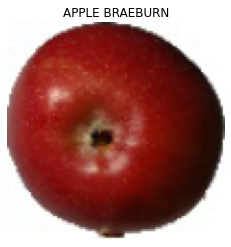

In [10]:
img = load_img(train_dir + '/' + train_fruits["Fruits Image"][1])
plt.title(train_fruits["Train Fruits"][1].upper())
plt.imshow(img)
plt.axis("off")
plt.show()

## Constructing CNN

## ResNet50

In [11]:
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(100,100,3), classes=131)

model = Sequential()
model.add(resnet50_model)
model.add(GlobalAvgPool2D())
#model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=131, activation='softmax'))
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 131)               268419    
                                                                 
Total params: 23,856,131
Trainable params: 23,803,011
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Create image data generators to generate batches of tensor image data.

In [13]:
# rescale imgae by 1./255 to keep all values in [0,1] since RGB values range from 0 to 255
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.2) # split 0.2 of the input for validation
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

# training
train_generator = train_data_generator.flow_from_directory(
        train_dir, # directory of training images
        target_size = (100, 100), # resize image to 100x100
        batch_size = 128,
        subset = 'training', # identify as training generator
        class_mode= 'categorical')

# validation
validation_generator = train_data_generator.flow_from_directory(
        train_dir, # directory of training images
        target_size = (100, 100),
        batch_size = 128,
        subset = 'validation', # identify as validation generator
        class_mode= 'categorical')

# testing
test_generator = test_data_generator.flow_from_directory(
        test_dir, # directory of testing images
        target_size = (100, 100),
        shuffle = False, # disable shuffle
        batch_size = 64,
        class_mode = 'categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Tell the model when to stop when calidation loss stop decrease for 3 consecutive times.

In [14]:
# callback used to stop the training early depending on validation loss
# restore the best weights
callback = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    min_delta = 0.01,
    patience = 4,
    restore_best_weights = True)

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 0.00001)

Fit the model using data from *train_generator*, train for 15 epochs, stop when validation accuracy did not improve in 3 epochs.

In [16]:
# fitting model
hist = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = [callback, reduce_lr])

Epoch 1/25
424/424 [==============================] - 107s 207ms/step - loss: 0.2257 - accuracy: 0.9454 - val_loss: 15.9474 - val_accuracy: 0.0068 - lr: 0.0010
Epoch 2/25
424/424 [==============================] - 86s 202ms/step - loss: 0.0380 - accuracy: 0.9901 - val_loss: 2.5705 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 3/25
424/424 [==============================] - 86s 202ms/step - loss: 0.0346 - accuracy: 0.9917 - val_loss: 0.1389 - val_accuracy: 0.9534 - lr: 0.0010
Epoch 4/25
424/424 [==============================] - 86s 202ms/step - loss: 0.0133 - accuracy: 0.9968 - val_loss: 0.5385 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 5/25
424/424 [==============================] - 86s 202ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0321 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 6/25
424/424 [==============================] - 86s 202ms/step - loss: 7.0368e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 7/25
424/424 [==========================

In [17]:
#np.save('history_resnet50_t.npy', hist.history)
#model.save_weights('checkpoint_resnet50_t.h5')

In [18]:
# history = np.load('history_resnet50.npy',allow_pickle='TRUE').item()
# model.load_weights('checkpoint_resnet50.h5')

Retrive the metrics and plot the accuracy and loss graphs.

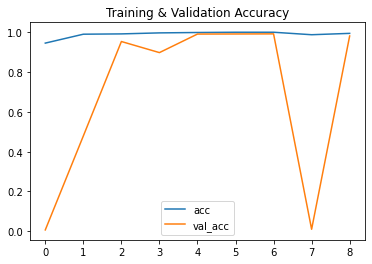

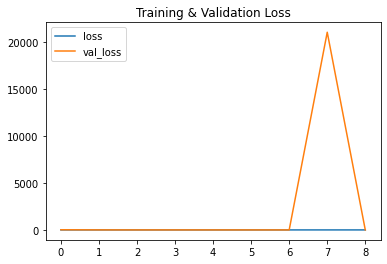

In [19]:
# retrieve results on training and validation data
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training & Validation Accuracy')
plt.legend()

# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.title('Training & Validation Loss')
plt.legend()

Make a prediction using the trained model on the *test_generator*, and record the output vectors.

In [20]:
# record the output vectors containing the probability of each class
pred = model.predict(test_generator)

Evaluate the loss and accuracy of the model on *train_generator*.

In [21]:
# record the loss and accuracy of the prediction
pred_loss_acc = model.evaluate(test_generator)

355/355 [==============================] - 17s 48ms/step - loss: 0.0366 - accuracy: 0.9918


Output the loss and accuracy of the prediction.

In [22]:
print(('Loss: {}\nAccuracy: {}%').format(round(pred_loss_acc[0], 2), round(100 * pred_loss_acc[1], 2)))

Loss: 0.04
Accuracy: 99.18%


## Visualization

The vectors in *pred* represent the probability of each class, take the one with the highest probability.

In [23]:
# get the index of the highest probable classes
predict_class_index = [np.argmax(element) for element in pred]

# convert index to string classes
predict_classes = [classes[i] for i in predict_class_index]

Compute the Confusion Matrix for Visualization

In [24]:
# compute the confusion matrix using prediction and testing labels
cf_matrix = confusion_matrix(predict_classes, label_test)

In [25]:
# compute the percentage of accuracy for each class in the confusion matrix
cf_matrix_percentage = cf_matrix / np.sum(cf_matrix, axis=0)

Plot the confusion matrix using Seaborn Heapmap

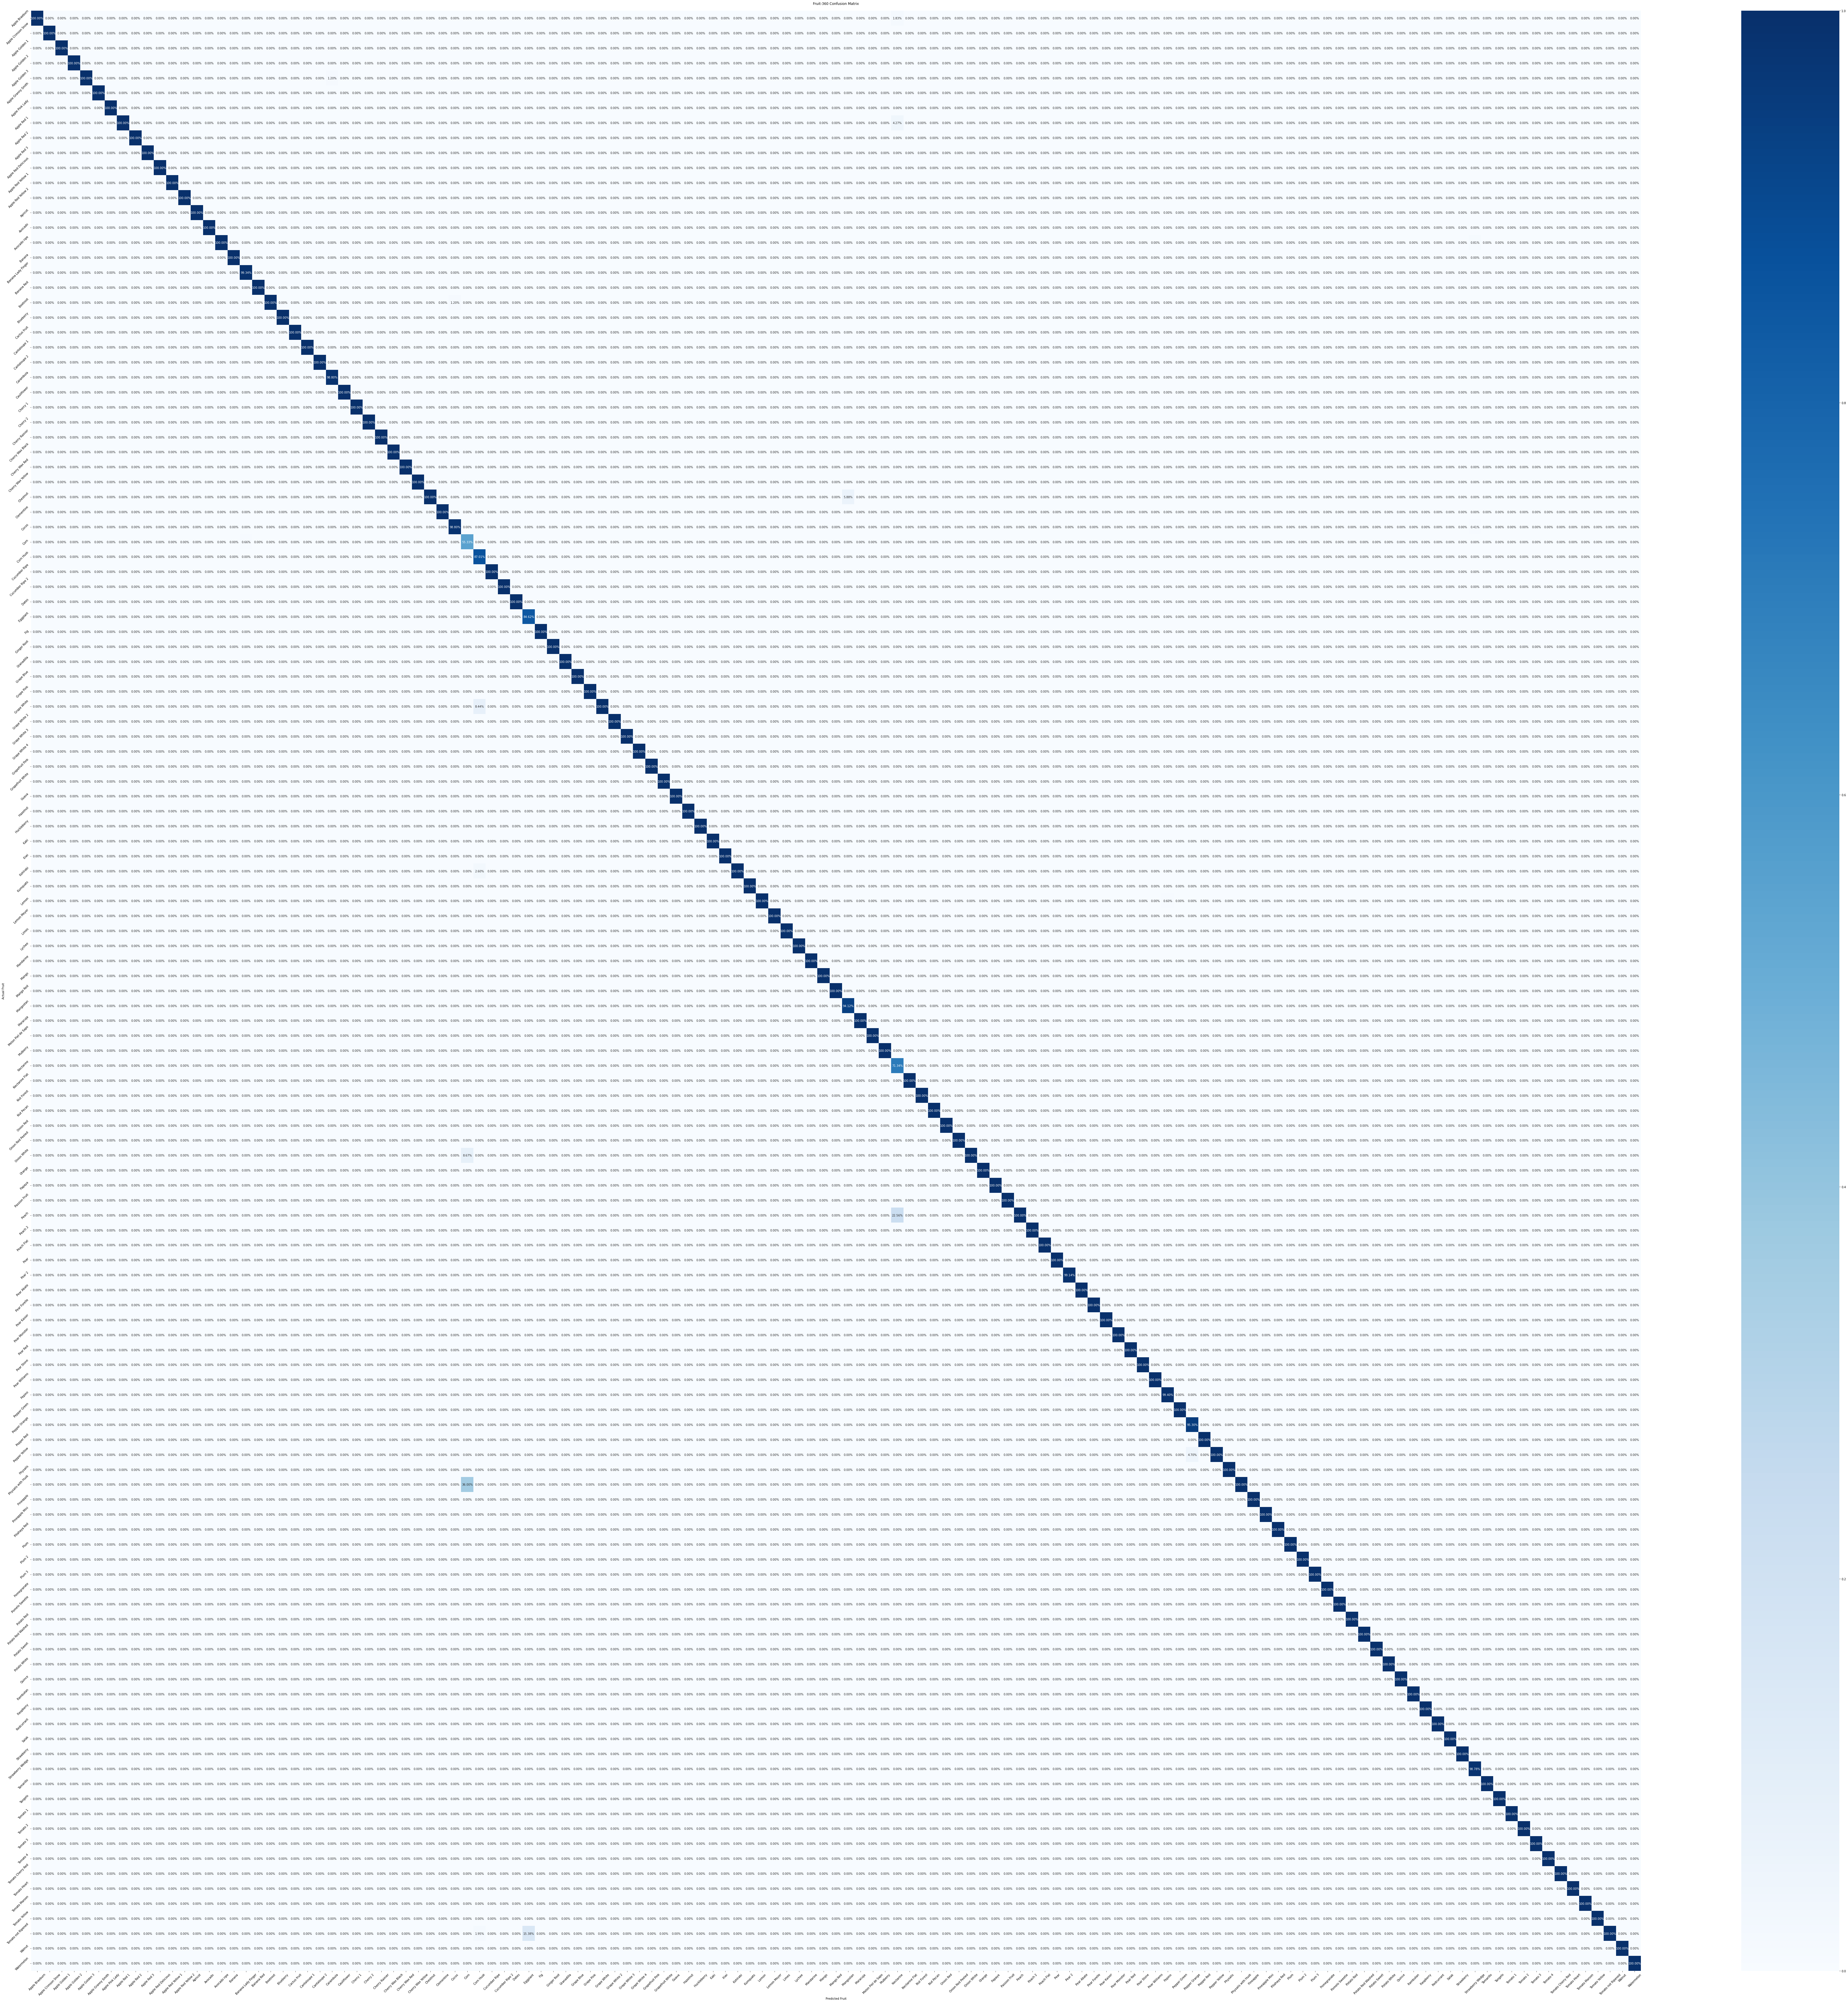

In [26]:
# plot the confusion matrix
plt.figure(figsize = (125,125))
ax = sns.heatmap(cf_matrix_percentage, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 Confusion Matrix\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels rotated 45 degrees
ax.xaxis.set_ticklabels(classes, rotation = 45)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.show()

A smaller confusion matrix that is part of the larger one.

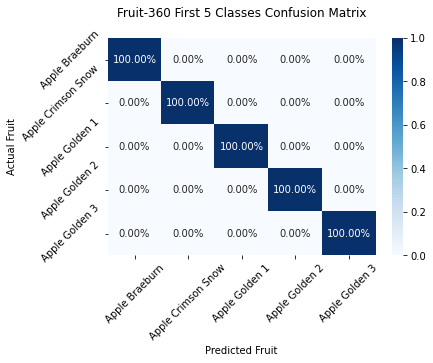

In [27]:
# plot the small confusion matrix
ax = sns.heatmap(cf_matrix_percentage[:5,:5], annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 First 5 Classes Confusion Matrix\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels of the first 5 classes rotated 45 degrees
ax.xaxis.set_ticklabels(classes[:5], rotation = 45)
ax.yaxis.set_ticklabels(classes[:5], rotation = 45)

plt.show()

In [28]:
# function that shows the percentage distribution of predictions for a certain class
def vis_spread(name):
    error_classes = []
    error_percentage = []
    index = classes.index(name) # get the index of the input fruit
    for i in range(len(classes)):
        if cf_matrix_percentage[i,index] != 0:
            error_classes.append(classes[i])
            error_percentage.append(round(cf_matrix_percentage[i,index] * 100, 2))
    
    error_classes = np.asarray(error_classes)
    error_percentage = np.asarray(error_percentage)
    index_desc = np.flip(np.argsort(error_percentage))
    error = pd.DataFrame(error_classes[index_desc], columns = ['Classes'])
    error[' Percentage'] = error_percentage[index_desc]
    error.index += 1
    print(error)

In [29]:
vis_spread('Apple Braeburn')

          Classes   Percentage
1  Apple Braeburn        100.0


In [30]:
vis_spread('Nectarine')

          Classes   Percentage
1       Nectarine        71.34
2           Peach        22.56
3     Apple Red 1         4.27
4  Apple Braeburn         1.83


In [31]:
vis_spread('Nut Pecan')

     Classes   Percentage
1  Nut Pecan        100.0


In [32]:
vis_spread('Apple Golden 3')

          Classes   Percentage
1  Apple Golden 3        100.0


In [33]:
# function that plots 15 random fruits with prediction and actual label
def plot_random():
    plt.figure(figsize=(16,9))
    sample_num = len(label_test)
    title = 'Predicted: {}\nActual: {}'
    for i in range(15):
        x = random.randint(0, sample_num)
        plt.subplot(3,5,i+1)
        img = load_img(test_dir + '/' + image_test[x])
        plt.imshow(img)
        plt.title(title.format(predict_classes[x], label_test[x]))
        plt.axis("off")

    plt.suptitle("Random Samples", fontsize = 20, fontweight = 'bold')
    plt.show()

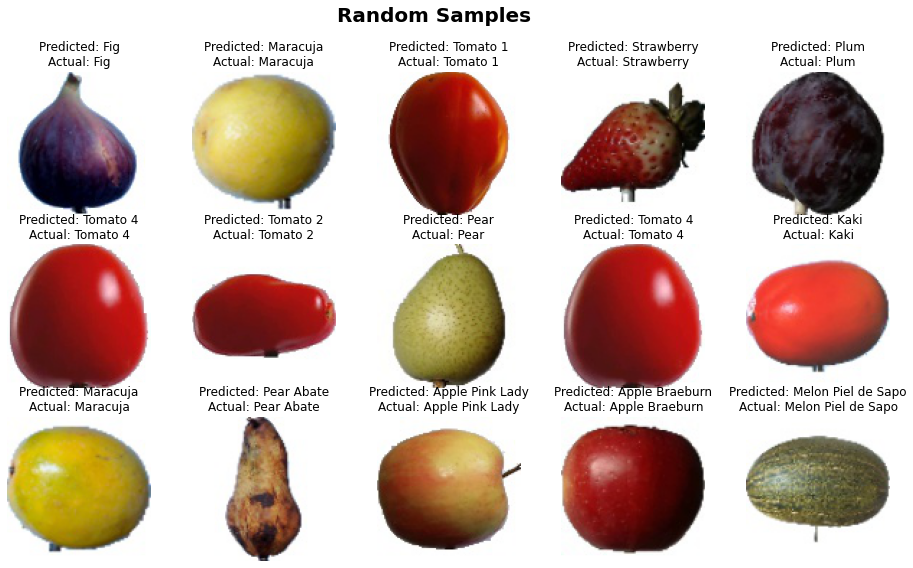

In [34]:
plot_random()

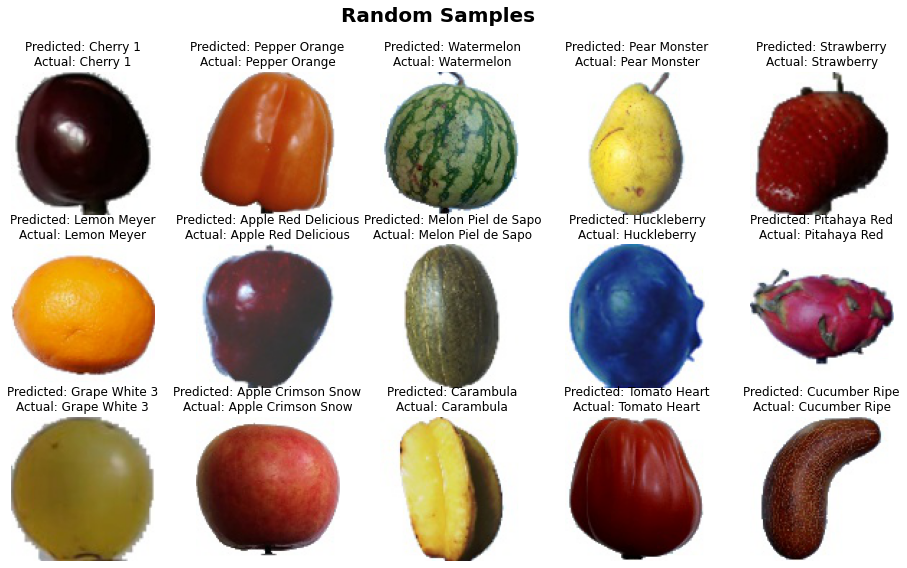

In [35]:
plot_random()

In [36]:
my_image = load_img("/Machine Learning/Fruit-360/other/3.jpg", target_size=(100, 100))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = model.predict(my_image)
classes[prediction.argmax()]

FileNotFoundError: ignored